# Introduction

## World Food Programme (WFP) hackathon

This analysis is for the WFP hackathon organised by DataMission. See http://www.datamission.nl/un-world-food-program-hackathon/ for more info.

## Data

Info about available datasets is in the wiki, see https://github.com/datamission/WFP/wiki/Datasets-wiki-page. The wiki contains much more info, see https://github.com/datamission/WFP/wiki.


## Goals

In this notebook we try to achieve the following: 
* Gain insight into factors influencing Reduced Coping Strategy Index (rCSI) and Food Consumption Score (FCS). See https://github.com/datamission/WFP/wiki/List-of-Acronyms for definitions
* Predict rCSI and FCS on more granular spatial level than currently available

## Current Questions

* What is distribution of food scores vs region, income, city/rural area, ..?
* Should we work with aggregated food scores or more granular survey data?
* Filter/select regions with enough data before training ML models?


## Todo

* Preprocess
  * Gather data
  * Clean data
  * Merge data sets on region (where possible) 
* Exploratory Analysis
  * Plot indicators on map
  * Plot aggregated survey answers
  * Histogram/plot of aggregated survey answers vs indicators
* Inference
  * Check variance for indicators per region
  * Check number of data points per region
* Machine Learning
  * Regression problem (mean food score per region, percent below certain threshold per region?)
  * Convert to classification problem?
  * Potentially useful algoritms: Naive Bayes, Decision Tree, Random Forest, KNN, Linear Regression, SVM

# Preprocess

## Gather data

In [1]:
# Libraries
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import shapefile as shp
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode() # run at the start of every notebook

#from biokit.viz import corrplot
#from sklearn import tree
#import graphviz

# Inline plotting with specific image size
% matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12 

In [2]:
# Current dir
os.getcwd()

'/home/dennis/git/hackhunger/code'

In [3]:
# Output directory
dir_results = "../results/"

# Data directories
dir_rainfall = "../data/yemen_rainfall/"
dir_yemen = "../data/USB/Yemen/"
dir_yemen_shapefiles = "../data/yemen_shapefiles/"

# Data files
file_foodprices_fao = dir_yemen + "YEM_FAO_FoodPrices.csv"
file_foodprices_wfp = dir_yemen + "YEM_WFP_FoodPrices_09-05-2016.csv"
file_marketlocations = dir_yemen + "YEM_WFP_Market-Locations.csv"
file_mvam = dir_yemen + "mVAM/Data/YEM_WFP_mVAM_RawData.csv"
file_cfss = dir_yemen + "CFSS/Data/YEM_CFSS_2014.csv"

# Shape files
file_shape = dir_yemen_shapefiles + "yem_bnd_adm2.shp"
file_shape_2 = dir_yemen_shapefiles + "yem_bnd_adm2"

In [85]:
# Read data
#df_foodprices_fao = pd.read_csv(file_foodprices_fao)   # Does not contain prices, only (irrelevant) commodity names
df_foodprices_wfp = pd.read_csv(file_foodprices_wfp)
df_marketlocations = pd.read_csv(file_marketlocations)
df_mvam = pd.read_csv(file_mvam)
df_cfss = pd.read_csv(file_cfss, encoding='iso-8859-1', low_memory=False)   # Use low_memory=False to prevent type error

## Clean data

In [86]:
# Create date variable from mp_year and mp_month
df_foodprices_wfp['date'] = df_foodprices_wfp.apply(lambda row: datetime.date(row.mp_year, row.mp_month, 1), axis=1)

In [87]:
# Convert ObsDate and SvyDate to dates
df_mvam['ObsDate'] = df_mvam.ObsDate.apply(lambda datestring: datetime.datetime.strptime(datestring, '%d%b%Y').date())
df_mvam['SvyDate'] = df_mvam.SvyDate.apply(lambda datestring: datetime.datetime.strptime(datestring, '%d%b%Y').date())

## Merge data

In [28]:
# Merge df_foodprices_wfp and df_marketlocations
df_foodprices = df_foodprices_wfp.merge(df_marketlocations, how='left', on='mkt_name')

In [ ]:
## TODO: Subsetting data (select relevant variables)

# Exploratory Analysis

## Size of data sets

In [88]:
len(df_foodprices_wfp)

3919

In [89]:
len(df_mvam)

20484

In [90]:
len(df_marketlocations)

8

In [91]:
len(df_cfss)

10556

## Explore Food Prices

In [10]:
# List of available commodities
def getcommodities(df_foodprices):
    return list(set(df_foodprices_wfp.cm_name))

In [11]:
def plotfoodprices(df_foodprices, commodity, show=True, save=False):
    # Select commodity
    df_foodprices_subset = df_foodprices_wfp[df_foodprices_wfp.cm_name==commodity]
    
    # Determine currency and unit
    currency=list(df_foodprices_subset.cur_name)[0]
    unit=list(df_foodprices_subset.um_name)[0]
    
    # Plot
    plotdata = {
        "data": [Scatter(
                x=df_foodprices_subset.date[df_foodprices_subset.mkt_name==market],
                y=df_foodprices_subset.mp_price[df_foodprices_subset.mkt_name==market],
                name=market
            ) for market in set(df_foodprices_subset.mkt_name)
                ],
        "layout": Layout(
            xaxis=XAxis(title="Date"),
            yaxis=YAxis(title="Price ("+currency+"/"+unit+")"),
            title="Price of "+commodity+" in Yemen"
        )
    }
    
    # Show plot
    if show:
        iplot(plotdata, show_link=False)

    # Save plot to file
    if save:
        file_output = dir_results + "foodprices_" + commodity + ".html"
        plot_file = plot(plotdata , filename = file_output,  auto_open=False, show_link=False)
        print(plot_file)

In [92]:
# Plot food prices for all commodities
for commodity in getcommodities(df_foodprices_wfp):
    plotfoodprices(df_foodprices_wfp, commodity, show=True, save=True)

file:///home/dennis/git/hackhunger/results/foodprices_Beans (kidney red).html


file:///home/dennis/git/hackhunger/results/foodprices_Lentils.html


file:///home/dennis/git/hackhunger/results/foodprices_Tomatoes.html


file:///home/dennis/git/hackhunger/results/foodprices_Eggs.html


file:///home/dennis/git/hackhunger/results/foodprices_Wheat.html


file:///home/dennis/git/hackhunger/results/foodprices_Salt.html


file:///home/dennis/git/hackhunger/results/foodprices_Peas (yellow, split).html


file:///home/dennis/git/hackhunger/results/foodprices_Potatoes.html


file:///home/dennis/git/hackhunger/results/foodprices_Onions.html


file:///home/dennis/git/hackhunger/results/foodprices_Oil (vegetable).html


file:///home/dennis/git/hackhunger/results/foodprices_Beans (white).html


file:///home/dennis/git/hackhunger/results/foodprices_Sugar.html


file:///home/dennis/git/hackhunger/results/foodprices_Rice (imported).html


file:///home/dennis/git/hackhunger/results/foodprices_Wheat flour.html


file:///home/dennis/git/hackhunger/results/foodprices_Fuel (petrol-gasoline).html


file:///home/dennis/git/hackhunger/results/foodprices_Fuel (diesel).html


## Food Prices data histograms

In [47]:
#df_foodprices_wfp.hist();

## mVAM histograms

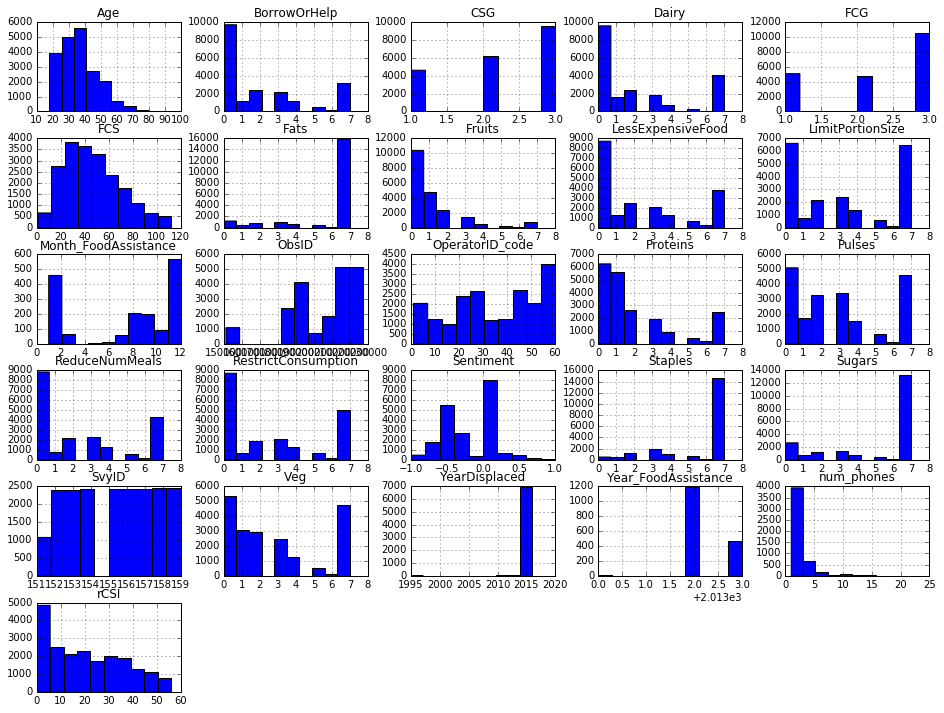

In [93]:
df_mvam.hist();

## CFSS histograms

In [46]:
#df_cfss.hist();

## Market Locations

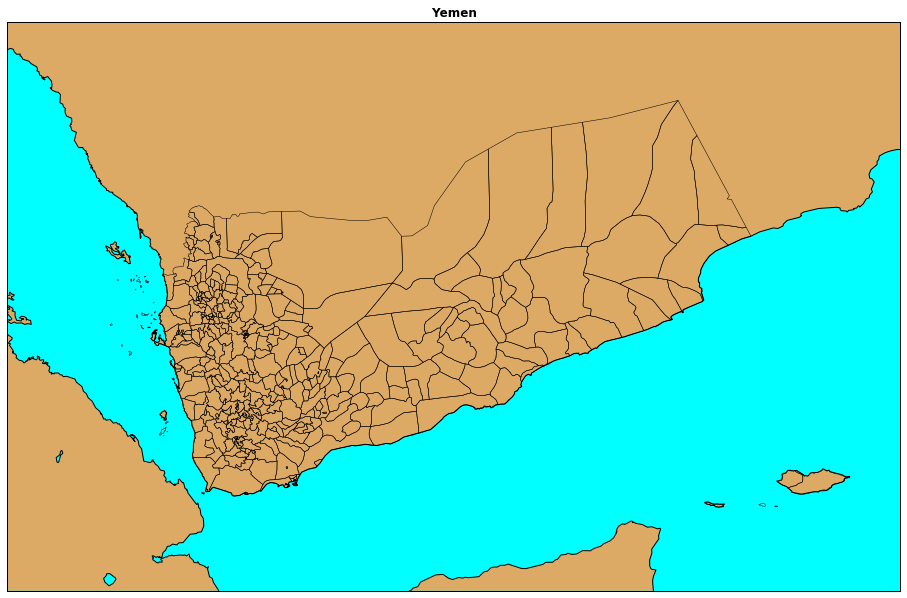

In [15]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(llcrnrlon=40,llcrnrlat=11,urcrnrlon=56,urcrnrlat=20,
             resolution='i', projection='tmerc', lat_0 = 11, lon_0 = 40)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='#ddaa66',lake_color='aqua')
map.drawcoastlines()

map.readshapefile(file_shape_2, 'yemen')

plt.title('Yemen', fontweight='bold')
plt.show()

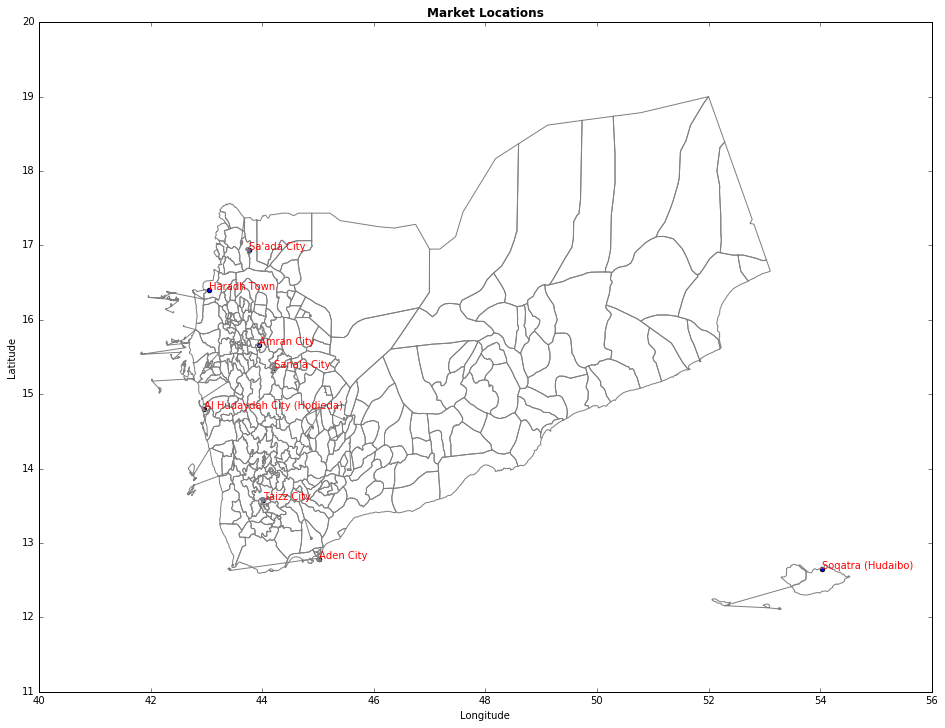

In [16]:
fig, ax = plt.subplots()
lng = df_marketlocations['mkt_lng']
lat = df_marketlocations['mkt_lat']
names = df_marketlocations['mkt_name']
sf = shp.Reader(file_shape)

# Plot shapefile
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y, color='grey')

# Plot market locations
ax.scatter(lng, lat)

# Plot market names
for nr, name in enumerate(names):
    ax.annotate(name, (lng[nr],lat[nr]), color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Market Locations', fontweight='bold')
plt.show()

# Machine Learning

# More Data Exploration

In [49]:
df_mvam.columns

Index(['ObsID', 'SvyID', 'SvyDate', 'RspID', 'ObsDate', 'OperatorID_code',
       'ADM0_NAME', 'REGION', 'ADM1_NAME', 'ADM2_NAME', 'Age', 'Gender',
       'HoHSex', 'IDP_YN', 'YearDisplaced', 'From_other_Governorate_YN',
       'DisplaceGovn', 'HouseType', 'Other_HouseType', 'Staples', 'Pulses',
       'Veg', 'Fruits', 'Proteins', 'Dairy', 'Sugars', 'Fats', 'FCS', 'FCG',
       'LessExpensiveFood', 'BorrowOrHelp', 'ReduceNumMeals',
       'LimitPortionSize', 'RestrictConsumption', 'rCSI', 'CSG',
       'FoodAssistance_YN', 'Month_FoodAssistance', 'Year_FoodAssistance',
       'Form_FoodAssistance', 'Sentiment', 'num_phones'],
      dtype='object')

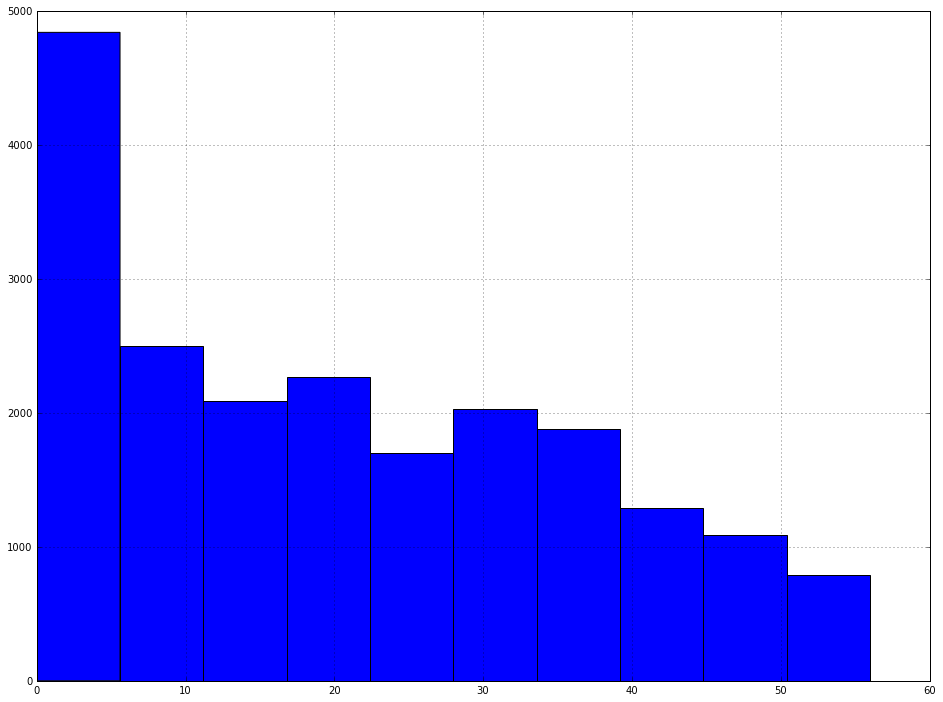

In [57]:
# Higher rCSI means worse food situation
df_mvam.rCSI.hist()

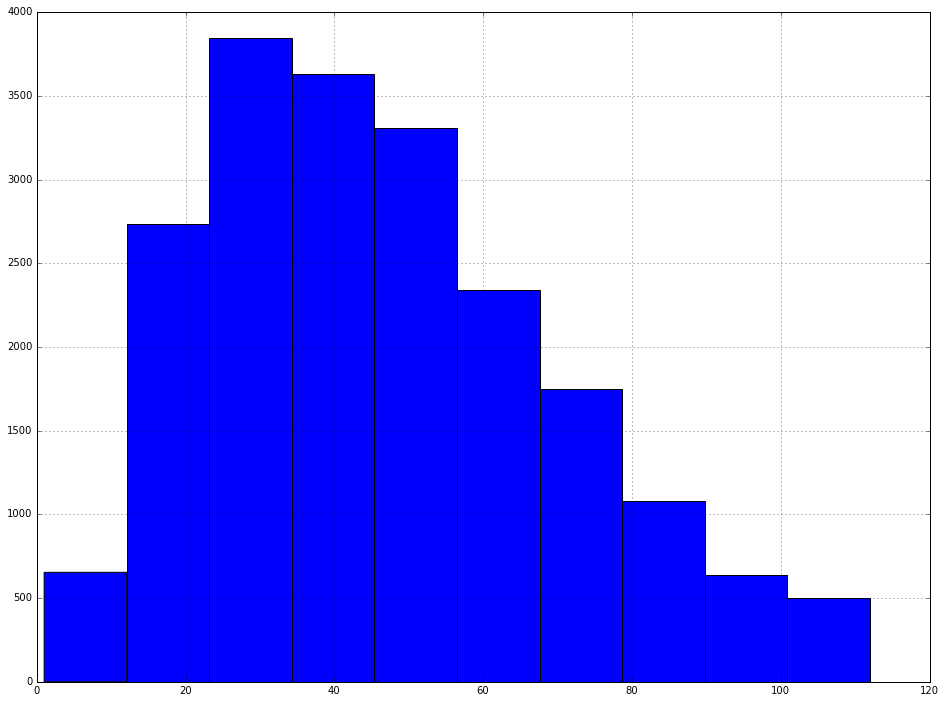

In [63]:
# JHigher FCS means better food situation
# Range of Food Consumption Score (FCS) is between 0 and 112. The standard thresholds are:
# <=21 FCS (poor consumption),21.5 to 35 (borderline consumption), >35 (acceptable consumption).
df_mvam.FCS.hist()

In [95]:
df_mvam.columns

Index(['ObsID', 'SvyID', 'SvyDate', 'RspID', 'ObsDate', 'OperatorID_code',
       'ADM0_NAME', 'REGION', 'ADM1_NAME', 'ADM2_NAME', 'Age', 'Gender',
       'HoHSex', 'IDP_YN', 'YearDisplaced', 'From_other_Governorate_YN',
       'DisplaceGovn', 'HouseType', 'Other_HouseType', 'Staples', 'Pulses',
       'Veg', 'Fruits', 'Proteins', 'Dairy', 'Sugars', 'Fats', 'FCS', 'FCG',
       'LessExpensiveFood', 'BorrowOrHelp', 'ReduceNumMeals',
       'LimitPortionSize', 'RestrictConsumption', 'rCSI', 'CSG',
       'FoodAssistance_YN', 'Month_FoodAssistance', 'Year_FoodAssistance',
       'Form_FoodAssistance', 'Sentiment', 'num_phones'],
      dtype='object')

In [94]:
df_mvam.head(3)

,ObsID,SvyID,SvyDate,RspID,ObsDate,OperatorID_code,ADM0_NAME,REGION,ADM1_NAME,ADM2_NAME,...,LimitPortionSize,RestrictConsumption,rCSI,CSG,FoodAssistance_YN,Month_FoodAssistance,Year_FoodAssistance,Form_FoodAssistance,Sentiment,num_phones
0,151140,151,2015-08-01,CTC250815A223,2015-08-25,23,Yemen,ALJANAD,IBB,IBB,...,0,0,7,2,N,NaN,NaN,None,0.000000,NaN
1,151141,151,2015-08-01,CTC230815A8,2015-08-23,43,Yemen,AZAL,AMRAN,AS SAWD,...,4,0,17,2,Y,8.0,2015.0,Cash,0.000000,NaN
2,151142,151,2015-08-01,CTC240815A85,2015-08-24,42,Yemen,ALJANAD,TAIZZ,AT TA'IZIYAH,...,7,7,44,3,Y,7.0,2015.0,NaN,-0.142554,NaN
